#ESTRATEGIA PELICULAS ASOCIADAS-SIMILARES, CINEPLANET CHILE

# Carga de Datos CinePlanet_Chile


Creación de la data consolidada de Cineplanet Chile, junto al dataframe 'historico de los ultimos meses' de todos los usuarios, teniendo en consieración el tipo de cluster al cual pertenece.


In [ ]:
'''
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
'''

!pip install pymysql
import pymysql
import numpy as np 
import pandas as pd


def Cluster_consolidado(nombre_tabla):

  connection = pymysql.connect(host="mel.analytics.cl", user="jcabeza",password="09jcabeza40",db="Cineplanet_Chile", port=33060)
  query = "SELECT CLI_ID , CLI_DNI , PEL_NOMBRE_COMERCIAL AS TITULO , PEL_ID , nuevo_cluster AS CLUSTER, IF(SUM(CANTIDAD)>=1, 1, 0) AS CONTEO , STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS FECHA FROM ((( "+nombre_tabla+" NATURAL JOIN Cineplanet_Chile.DIM_CLIENTE) NATURAL JOIN Cineplanet_Chile.BOLETERIA ) NATURAL JOIN Cineplanet_Chile.DIM_PELICULA) WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 1 WEEK) GROUP BY CLI_ID,  TITULO ORDER BY CLI_ID ASC;" 
  data = pd.read_sql(query, connection)
  df_cluster = pd.pivot_table(data, index=['CLI_ID','CLUSTER'], columns='TITULO', values='CONTEO').fillna(0).reset_index()
  df_identificador = data[['CLI_ID', 'CLI_DNI', 'CLUSTER']]
  #print(df_cluster.shape)
  return df_cluster, df_identificador

meses = ['cparra.cineplanet_abril', 'cparra.cineplanet_mayo', 'cparra.cineplanet_junio', 'cparra.cineplanet_agosto']

data_consolidado = pd.DataFrame([])
df_identificador = pd.DataFrame([])
for mes in meses:
  consolidado, identificador = Cluster_consolidado(mes)
  data_consolidado = data_consolidado.append(pd.DataFrame(consolidado), ignore_index=True)
  
  df_identificador = df_identificador.append(pd.DataFrame(identificador), ignore_index=True)
   

data_consolidado = data_consolidado.groupby(['CLI_ID']).agg('sum')
print('Dimension dataframe consolidado', data_consolidado.shape)

valores = {10:1, 9:1, 8:1, 7:1, 6:1, 5:1, 4:1, 3:1, 2:1, 1:1, 0:0}
data_consolidado.replace(valores, inplace=True)

df_identificador = df_identificador.drop_duplicates(subset=['CLI_ID', 'CLI_DNI'], keep = 'last')  
print('Dimension dataframe con los identificadores', df_identificador.shape)



You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Dimension dataframe consolidado (279966, 89)
Dimension dataframe con los identificadores (279966, 3)


De la data anterior, generamos el dataframe 'data_usuario', el cual tiene la ID del usuario, peliculas vistas en un periodo de seis meses, codigo DNI y Cluster.

In [ ]:
data_usuario = pd.merge(data_consolidado, df_identificador, on='CLI_ID', how='inner')

print('Dimension del dataframe data_usuario es,',data_usuario.shape)
data_usuario.head(3)

NameError: ignored

Creación base de datos de las peliculas de los ultimos seis meses. Recordar que este proceso se implementará de manera semanal, por esta razón dentro del top de peliculas recomedadas por cliente, determinaremos sus atributos predominantes y determinamos un coeficiente de correlación con las peliculas de estreno semanal.

In [ ]:
connection = pymysql.connect(host="mel.analytics.cl", user="jcabeza",password="09jcabeza40",db="Cineplanet_Chile", port=33060)
query = "SELECT PEL_ID, PEL_CODIGO, PEL_NOMBRE_COMERCIAL AS TITULO, PEL_GENERO, STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS Fecha_ESTRENO FROM DIM_PELICULA WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') >= DATE_SUB(NOW(), INTERVAL 6 MONTH);"
#query = "SELECT PEL_ID, PEL_CODIGO, PEL_NOMBRE_COMERCIAL AS TITULO, PEL_GENERO, STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS Fecha_ESTRENO FROM DIM_PELICULA WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 3.5 WEEK);"
movies = pd.read_sql(query, connection)

print('Dimension dataframe movies', movies.shape)
movies.tail(3)

Dimension dataframe movies (103, 5)


,PEL_ID,PEL_CODIGO,TITULO,PEL_GENERO,Fecha_ESTRENO
100,4421,TOY STORY 4,TOY STORY 4,00,2019-06-20
101,4422,UN PANDA EN APUROS,UN PANDA EN APUROS,00,2019-06-06
102,4423,X-MEN: DARK PHOENIX,X-MEN: DARK PHOENIX,00,2019-06-06


In [ ]:
# Data excel, con el historial de las peliculas de estos ultimos seis meses, para realizar algún web scraping y obtener data adicional.

#export_csv = movies.to_csv (r'export_dataframe.csv', index = True, header=True) 


# Estrategia por Cluster

In [ ]:
# En la implementación final, incluir lista de cluster. Tomar en cuenta que el cluster Bajo presenta 136.224 registros solo en Agosto.
'''
Cineplanet_Cluster = ['BLACK', 'ORO', 'JOVEN', 'TOP', 'FAMILIAR', 'BAJO']

for cluster in Cineplanet_Cluster: -> resto del codigo
'''

  
print('Tabla de peliculas de estreno ultima semana, realizado!')

Cluster_Cineplanet = ['FAMILIAR']#'BLACK', 'ORO', 'JOVEN', 'TOP'

##########################################################################################
############################ ITERACION POR CLUSTER DE CLIENTE ############################
##########################################################################################

for cluster in Cluster_Cineplanet:

  clientes_cluster = data_usuario[data_usuario.CLUSTER == 'FAMILIAR']
  clientes_cluster.index = clientes_cluster.CLI_ID
  clientes_cluster = clientes_cluster.drop(['CLI_ID','CLI_DNI','CLUSTER'], axis=1)

  
clientes_cluster.shape

Tabla de peliculas de estreno ultima semana, realizado!


(75972, 89)

In [ ]:
#Solo para fines de calculo, seleccionamos un subgrupo del dataframe
clientes_cluster = clientes_cluster.iloc[0:500]
clientes_cluster.shape

(500, 89)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

#similaridad = linear_kernel(clientes_cluster, clientes_cluster), esto lo modificamos 

similarity = np.dot(clientes_cluster, clientes_cluster.T)
square_mag = np.diag(similarity)
inv_square_mag = 1 / square_mag
inv_square_mag[np.isinf(inv_square_mag)] = 0
inv_mag = np.sqrt(inv_square_mag)
cosine = similarity * inv_mag.astype(np.float16)
similaridad = (cosine.T).astype(np.float16) * inv_mag.astype(np.float16)

similaridad

array([[1.    , 0.707 , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.707 , 1.    , 0.707 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.707 , 1.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.9995, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float16)

In [ ]:

df_identificador_CLUSTER = df_identificador[df_identificador.CLUSTER == 'FAMILIAR']
df_identificador_CLUSTER.reset_index(inplace = True)

Función para entregar los usuarios mas parecidos al usuario objetivo, por cluster.

In [ ]:
def get_recommendations(nombre):
  idx = df_identificador_CLUSTER[df_identificador_CLUSTER['CLI_ID'] == nombre].index.item()
  sim_scores = list(enumerate(similaridad[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[0:31]
  clientes_indices = [+i[0] for i in sim_scores]
  return df_identificador_CLUSTER.iloc[clientes_indices].CLI_ID

In [ ]:
recomendar = pd.DataFrame({'clientes':[],'rec1':[], 'rec2':[], 'rec3':[], 'rec4':[], 'rec5':[]})

j=0
for id_cli in df_identificador_CLUSTER['CLI_ID'].tolist():
  recomendaciones = get_recommendations(id_cli)
  #print(recomendaciones)
  bla = pd.DataFrame({'clientes':[str(id_cli)],'rec1':[str(recomendaciones[recomendaciones.index[0]])], 'rec2':[str(recomendaciones[recomendaciones.index[1]])], 
                    'rec3':[str(recomendaciones[recomendaciones.index[2]])], 'rec4':[str(recomendaciones[recomendaciones.index[3]])], 
                                             'rec5':[str(recomendaciones[recomendaciones.index[4]])]})
  recomendar = recomendar.append(bla)
  j=j+1
  if j==100:
      break

In [ ]:
recomendar = recomendar.drop_duplicates()
recomendar = recomendar.reset_index()
recomendar = recomendar.drop(['index'], axis=1)
recomendar.index=recomendar.clientes

recomendar.head()

,clientes,rec1,rec2,rec3,rec4,rec5
clientes,,,,,,
711673,711673,711673,712754,712915,712958,713248
711700,711700,711700,726273,711673,711706,711714
711706,711706,711706,711714,711747,711773,711797
711714,711714,711706,711714,711747,711773,711797
711736,711736,711736,711888,712835,713030,713541


In [ ]:

import datetime

df_identificador_CLUSTER.columns = [c.lower() for c in df_identificador_CLUSTER.columns]
fechas = pd.to_datetime(movies.Fecha_ESTRENO, infer_datetime_format=True)
fecha_corte = fechas.max() - datetime.timedelta(weeks=5)
peliculas_cartelera = [p.lower() for p in movies.TITULO[fechas>fecha_corte]]
peliculas_cartelera=peliculas_cartelera[:2]+peliculas_cartelera[4:]
 


print(clientes_cluster.columns)
  
print('Dimension de clientes_cluster es,',clientes_cluster.shape)
print('Peliculas de cartelera son,',peliculas_cartelera)


Index([' EL PRÍNCIPE ENCANTADOR', 'A DOS METROS DE TI',
       'AFTER: AQUÍ EMPIEZA TODO', 'ALADDIN', 'ANNABELLE 3: VIENE A CASA',
       'AVENGERS: ENDGAME', 'BRIGHTBURN, HIJO DE LA OSCURIDAD',
       'BTS BRING THE SOUL: LA PELICULA', 'CAPITANA MARVEL',
       'CEMENTERIO MALDITO', 'CICLO ANIME 2019: AKIRA',
       'CICLO ANIME 2019: COWBOY BEBOP', 'CICLO ANIME 2019: MI VECINO TOTORO',
       'CICLO ANIME 2019: MILLENNIUM ACTRESS',
       'CICLO ANIME 2019: SAILOR MOON R THE MOVIE',
       'CICLO ANIME 2019: YOUR NAME', 'CICLO ANIME: EL CASTILLO EN EL CIELO',
       'CICLO ANIME: LA PRINCESA MONONOKE', 'CICLO ANIME: MI VECINO TOTORO',
       'CICLO ANIME: SAILOR MOON R THE MOVIE', 'CINE ARTE 2019: BOY DONT CRY',
       'CINE ARTE 2019: EL EXORCISTA', 'CINE ARTE 2019: EL PIANISTA',
       'CINE ARTE 2019: EL SECRETO DE SUS OJOS', 'CINE ARTE 2019: KILL BILL',
       'CINE ARTE 2019: LOS PAJAROS', 'CINE ARTE 2019: ORGULLO Y PREJUICIO',
       'CINE ARTE 2019: YELLOW SUBMARINE', 'CINE AR

Recomendaciones por usuario (en cada cluster), con el top 8 peliculas.

In [ ]:
recomendaciones = {}
j=0
for i in range(len(recomendar.clientes)):
  recomendaciones[recomendar.iloc[i].clientes] = []
  for pel in peliculas_cartelera:
    v=0
    for id_cli in recomendar.iloc[i][['rec1','rec2','rec3','rec4','rec5']]:
      if clientes_cluster.loc[int(id_cli)][peliculas_cartelera == pel] == 1:
        v=v+1
      else:
        v=v
    if v>0:
      recomendaciones[recomendar.iloc[i].clientes].append(pel)
      
recomendaciones

# Recargar clientes_cluster, yaque para los calculos ocupe solo 150 rows.

{'711673': [],
 '711700': [],
 '711706': [],
 '711714': [],
 '711736': [],
 '711747': [],
 '711773': [],
 '711791': [],
 '711796': [],
 '711797': [],
 '711803': [],
 '711881': [],
 '711887': [],
 '711888': [],
 '711900': [],
 '711910': [],
 '711911': [],
 '711917': [],
 '711926': [],
 '711942': [],
 '711956': [],
 '712040': [],
 '712051': [],
 '712070': [],
 '712115': [],
 '712142': [],
 '712170': [],
 '712179': [],
 '712239': [],
 '712280': [],
 '712290': [],
 '712353': [],
 '712422': [],
 '712454': [],
 '712483': [],
 '712485': [],
 '712487': [],
 '712490': [],
 '712522': [],
 '712534': [],
 '712564': [],
 '712577': [],
 '712604': [],
 '712688': [],
 '712726': [],
 '712754': [],
 '712835': [],
 '712915': [],
 '712927': [],
 '712932': [],
 '712958': [],
 '712994': [],
 '713030': [],
 '713101': [],
 '713143': [],
 '713246': [],
 '713248': [],
 '713367': [],
 '713452': [],
 '713475': [],
 '713499': [],
 '713505': [],
 '713528': [],
 '713541': [],
 '713542': [],
 '713558': [],
 '713580':

Transformamos el archivo json anterior, en un dataframe llamado `data_recomendacion` con la información del usuario y las peliculas recomendadas

In [ ]:
data_recomendacion = pd.DataFrame.from_dict(recomendaciones, orient='index')
data_recomendacion.reset_index(level=0, inplace=True)

print(data_recomendacion.shape)

data_recomendacion.head(100)

(100, 9)


,index,0,1,2,3,4,5,6,7
0,742588,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
1,766885,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
2,837115,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
3,897481,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
4,1322336,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
5,1392966,None,None,None,None,None,None,None,None
6,1408616,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
7,1431827,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
8,1566086,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león
9,1578101,avengers: endgame extendida,bts bring the soul: la pelicula,dogman,el bosque maldito,el muñeco diabólico,paw patrol: mighty pups,rápidos y furiosos: hobbs & shaw,el rey león


# Creación base de datos películas

Ahora, dado que la estrategia se aplica de manera semanal, debemos ver entre la selección de peliculas recomendadas cuales son sus principales atributos, es decir, estamos mezclando los **filtros colaborativos basado en usuario** (Estrategia pelicula Asociada) y **basada en el contenido** (Estrategia pelicula Similar). De esta manera sacamos un 'coeficiente de correlación', entre los atributos que posean mayor importancia para cada ususario. Para esto probamos con un modelo del tipo, suponiendo que es lineal (...), 

$$Valoracion(x) = \alpha_{1}Genre(x)+\alpha_{2}Director(x)+\alpha_{3}Plot(x)+\varepsilon(x)$$


In [ ]:
!pip install nltk
!pip install unidecode

import urllib.request, urllib.parse, urllib.error
from urllib.parse import urlencode, urlparse, parse_qs
from bs4 import BeautifulSoup
import requests
import time
import pymysql
import json
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import warnings

warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')


from selenium import webdriver 
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
from unidecode import unidecode


def search_movie(id_movie):
	serviceurl = 'http://www.omdbapi.com/?'
	apikey = '&apikey='+"80a69346"#"e0dd629a" # el segundo numero es la api key
	if len(id_movie) < 1 or id_movie=='quit': 
		print("Goodbye now...")
		return None
	try:
		url = serviceurl + urllib.parse.urlencode({'i': id_movie})+apikey
		#print(f'Retrieving the data of "{id_movie}" now... ')
		uh = urllib.request.urlopen(url)
		data = uh.read()
		json_data=json.loads(data)
		return(json_data)
	except urllib.error.URLError as e:
		#print(f"ERROR: {e.reason}")
		return None

def getOmdData(title):
	actual_title = re.sub("[*].*$","",title)
	actual_title_list =  actual_title.split(" ")
	actual_title_query = "%20".join(actual_title_list)
	actual_title_query = "https://www.imdb.com/find?s=all&q="+actual_title_query+"&ref_=nv_sr_sm"
	
	time.sleep(1)
	req = requests.get(actual_title_query)
	soup = BeautifulSoup(req.text, "lxml")
	actual_title_webscrape = soup.select('.primary_photo a')
	movie_id = str(actual_title_webscrape).split('/')[2]
	actual_title_params = search_movie(movie_id)

	return actual_title_params

def find_title(query):
  query = re.sub(r'[^a-zA-Z\s]', "", query).lower()
  url = "https://www.google.com/search?q="+query+" movie wikipedia"
  chromedriver = "C:\webdrivers\chromedriver.exe"
  chrome_options = Options() 
  chrome_options.add_argument("--headless")
  driver = webdriver.Chrome(executable_path=chromedriver,chrome_options=chrome_options) 
  driver.get(url)
  driver.find_element_by_class_name('LC20lb').click()
  name = driver.find_element_by_tag_name('th').text  
  driver.close()
  return name 

def search_movie_aux(title):
	serviceurl = 'http://www.omdbapi.com/?'
	apikey = '&apikey='+"e0dd629a" # el segundo numero es la api key
	if len(title) < 1 or title=='quit': 
		print("Goodbye now...")
		return None
	elif (title=='NO_ENCONTRADO') | (title=='Cinema +'):
		print("Goodbye now...")
		return None
	try:
		url = serviceurl + urllib.parse.urlencode({'t': title})+apikey
		#print(f'Retrieving the data of "{title}" now... ')
		uh = urllib.request.urlopen(url)
		data = uh.read()
		json_data=json.loads(data)
		return(json_data)
	except urllib.error.URLError as e:
		#print(f"ERROR: {e.reason}")
		return None

########################### CREACION DEL DATASET ###########################

def create_dataset(titles):
	dataset = pd.DataFrame(columns=['Actors','Country','Director'
		,'Genre','Language','Metascore','Plot','Production','Released'
		,'Runtime','Title','Year','imdbRating','imdbVotes'])
	not_founds=[]
	titulo_original=[]
	i=1
	tiempo_ejecucion = []
	for tit in titles:
		time1 = time.time()
		print(i,". ", tit)
		try:
			pelicula = getOmdData(tit)
			bla = pd.DataFrame({'Actors': [pelicula['Actors']]
				,'Country':[pelicula['Country']]
				,'Director' : [pelicula['Director']]
				,'Genre':[pelicula['Genre']]
				,'Language':[pelicula['Language']]
				,'Metascore':[pelicula['Metascore']]
				,'Plot':[pelicula['Plot']]
				,'Production':[pelicula['Production']]
				,'Released':[pelicula['Released']]
				,'Runtime':[pelicula['Runtime']]
				,'Title':[pelicula['Title']]
				,'Year':[pelicula['Year']]
				,'imdbRating':[pelicula['imdbRating']]
				,'imdbVotes':[pelicula['imdbVotes']]
				})
			titulo_original.append(pelicula['Title'])
			dataset = dataset.append(bla)
			print('('+tit+' Realizada correctamente!!!)')
		except:
			try:
				tit_aux = find_title(tit)
				print(tit_aux)
				pelicula = search_movie_aux(unidecode(tit_aux))
				bla = pd.DataFrame({'Actors': [pelicula['Actors']]
					,'Country':[pelicula['Country']]
					,'Director' : [pelicula['Director']]
					,'Genre':[pelicula['Genre']]
					,'Language':[pelicula['Language']]
					,'Metascore':[pelicula['Metascore']]
					,'Plot':[pelicula['Plot']]
					,'Production':[pelicula['Production']]
					,'Released':[pelicula['Released']]
					,'Runtime':[pelicula['Runtime']]
					,'Title':[pelicula['Title']]
					,'Year':[pelicula['Year']]
					,'imdbRating':[pelicula['imdbRating']]
					,'imdbVotes':[pelicula['imdbVotes']]
					})
				titulo_original.append(pelicula['Title'])
				dataset = dataset.append(bla)
				print('('+tit+' Realizada correctamente!!!)')
			except:
				titulo_original.append('NO ENCONTRADO')
				not_founds.append(tit)
				bla = pd.DataFrame({'Actors': [np.nan]
					,'Country':[np.nan]
					,'Director' : [np.nan]
					,'Genre':[np.nan]
					,'Language':[np.nan]
					,'Metascore':[np.nan]
					,'Plot':[np.nan]
					,'Production':[np.nan]
					,'Released':[np.nan]
					,'Runtime':[np.nan]
					,'Title':[np.nan]
					,'Year':[np.nan]
					,'imdbRating':[np.nan]
					,'imdbVotes':[np.nan]
					})
				dataset = dataset.append(bla)
				print('(FALLA!!!)')
		time2 = time.time()
		tiempo_ejecucion.append(time2 - time1)
		i=i+1
	print("tiempo de ejecucion: ", np.sum(tiempo_ejecucion)/60)
	dataset = dataset.reset_index(drop=True)
	print("Fin de busqueda de informacion sobre peliculas")
	print("No Encontrados: ", not_founds)
	print(len(not_founds))
	print()
	return dataset



You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to C:\Users\Juan
[nltk_data]     Cabeza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Cabeza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dadas las funciones anteriores, podemos crear una base de datos para las peliculas de los ultimos seis meses.

In [ ]:
data_movie = create_dataset(movies.TITULO)

1 .  CAPITANA MARVEL
(CAPITANA MARVEL Realizada correctamente!!!)
2 .  EL MANICOMIO: LA CUNA DEL TERROR
(EL MANICOMIO: LA CUNA DEL TERROR Realizada correctamente!!!)
3 .  MALIGNO
(MALIGNO Realizada correctamente!!!)
4 .  REPLICAS
(REPLICAS Realizada correctamente!!!)
5 .   EL PRÍNCIPE ENCANTADOR
( EL PRÍNCIPE ENCANTADOR Realizada correctamente!!!)
6 .  A DOS METROS DE TI
(A DOS METROS DE TI Realizada correctamente!!!)
7 .  AFTER: AQUÍ EMPIEZA TODO
(AFTER: AQUÍ EMPIEZA TODO Realizada correctamente!!!)
8 .  CEMENTERIO MALDITO
(CEMENTERIO MALDITO Realizada correctamente!!!)
9 .  CICLO ANIME: LA PRINCESA MONONOKE
(FALLA!!!)
10 .  CINE ARTE CLÁSICO: ANGEL - A
(FALLA!!!)
11 .  CINE ARTE CLÁSICO: BRAZIL
(FALLA!!!)
12 .  CINE ARTE CLÁSICO: GUMMO
(FALLA!!!)
13 .  CINE ARTE CLÁSICO: MULHOLLAND DRIVE
(FALLA!!!)
14 .  CLIMAX
(CLIMAX Realizada correctamente!!!)
15 .  DUMBO
(DUMBO Realizada correctamente!!!)
16 .  FLOW
(FLOW Realizada correctamente!!!)
17 .  LA MISMA SANGRE
(LA MISMA SANGRE Realizad

In [ ]:
data_movie['PEL_NOMBRE_COMERCIAL'] = movies.TITULO
data_movie['ID_CINEPLANET'] = movies.PEL_ID



print(data_movie.shape)
data_movie.head(3)


(106, 16)


,Actors,Country,Director,Genre,Language,Metascore,Plot,Production,Released,Runtime,Title,Year,imdbRating,imdbVotes,PEL_NOMBRE_COMERCIAL,ID_CINEPLANET
0,"Brie Larson, Samuel L. Jackson, Ben Mendelsohn...",USA,"Anna Boden, Ryan Fleck","Action, Adventure, Sci-Fi",English,64,Carol Danvers becomes one of the universe's mo...,Marvel Studios,08 Mar 2019,123 min,Captain Marvel,2019,7.0,"348,490",CAPITANA MARVEL,4315
1,"Nilam Farooq, Farina Flebbe, Sonja Gerhardt, M...",Germany,Michael David Pate,"Horror, Thriller",German,N/A,"In HEILSTÄTTEN, a remote and gloomy sanctuary ...",N/A,22 Feb 2018,89 min,Heilstätten,2018,4.1,776,EL MANICOMIO: LA CUNA DEL TERROR,4318
2,"Taylor Schilling, Jackson Robert Scott, Peter ...","USA, Canada",Nicholas McCarthy,"Horror, Thriller",English,45,A mother concerned about her young son's distu...,N/A,08 Feb 2019,92 min,The Prodigy,2019,5.9,"13,931",MALIGNO,4323


Una vez que obtuvimos los atributos para cada pelicula vista por el usuario objetivo, debemos calcular la similaridad que posean estos atributos con las peliculas de la semana de estreno y seleccionar las mas parecidas.

Por otra parte, las peliculas de estreno están en la base de datos de "Cineplanet_Chile" en "PELICULAS_VIGENTES".

In [ ]:
import pymysql
import warnings
import pandas as pd

connection = pymysql.connect(host="mel.analytics.cl", user="jterrazas",password="11jterrazas54",db="Cineplanet_Chile", port=33060)


#query = "SELECT SUBSTRING(`PELICULAS_VIGENTES`.id, 8, 10) AS PEL_ID, `PELICULAS_VIGENTES`.titulo AS TITULO, STR_TO_DATE(`DIM_PELICULA`.PEL_FECHA_ESTRENO, '%m/%d/%Y') AS Fecha FROM `PELICULAS_VIGENTES` INNER JOIN `DIM_PELICULA` ON `PELICULAS_VIGENTES`.titulo COLLATE utf8_general_ci = `DIM_PELICULA`.PEL_NOMBRE_COMERCIAL COLLATE utf8_general_ci;"

query = "SELECT * FROM `PELICULAS_VIGENTES`;"
peliculas_vigentes = pd.read_sql(query, connection)

Creamos una base de datos para las peliculas vigentes

In [ ]:
data_movie_vigentes = create_dataset(peliculas_vigentes.titulo)

1 .  CINE ARTE 2019: ENTREVISTA CON EL VAMPIRO
(FALLA!!!)
2 .  PRESIDENTE BAJO FUEGO
(PRESIDENTE BAJO FUEGO Realizada correctamente!!!)
3 .  LA MÚSICA DE MI VIDA
(LA MÚSICA DE MI VIDA Realizada correctamente!!!)
4 .  METALLICA & SAN FRANCISCO SYMPHONY: S&M2
(FALLA!!!)
5 .  HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD
(HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD Realizada correctamente!!!)
6 .  BODA SANGRIENTA
(BODA SANGRIENTA Realizada correctamente!!!)
7 .  ARAÑA
(ARAÑA Realizada correctamente!!!)
8 .  RÁPIDOS Y FURIOSOS: HOBBS & SHAW
(RÁPIDOS Y FURIOSOS: HOBBS & SHAW Realizada correctamente!!!)
9 .  IT: CAPÍTULO 2
(IT: CAPÍTULO 2 Realizada correctamente!!!)
10 .  IT: CAPITULO 1
(FALLA!!!)
11 .  PAW PATROL: MIGHTY PUPS
(FALLA!!!)
12 .  LA VIDA SECRETA DE TUS MASCOTAS 2
(LA VIDA SECRETA DE TUS MASCOTAS 2 Realizada correctamente!!!)
13 .  EL REY LEÓN
(EL REY LEÓN Realizada correctamente!!!)
14 .  ANNABELLE 3: VIENE A CASA
(ANNABELLE 3: VIENE A CASA Realizada correctamente!!!)
15 . 

In [ ]:
data_movie_vigentes['PEL_NOMBRE_COMERCIAL'] = peliculas_vigentes.titulo
data_movie_vigentes['ID_CINEPLANET'] = movies.PEL_ID

data_movie_vigentes

,Actors,Country,Director,Genre,Language,Metascore,Plot,Production,Released,Runtime,Title,Year,imdbRating,imdbVotes,TITULO,PEL_NOMBRE_COMERCIAL,ID_CINEPLANET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINE ARTE 2019: ENTREVISTA CON EL VAMPIRO,CINE ARTE 2019: ENTREVISTA CON EL VAMPIRO,4315
1,"Roy Scheider, Patrick Muldoon, Maria Conchita ...",USA,John Terlesky,"Action, Adventure, Thriller",English,N/A,Secret Service agents must retrieve the briefc...,Studio Home Entertainment,22 Jul 2000,96 min,Chain of Command,2000,4.8,770,PRESIDENTE BAJO FUEGO,PRESIDENTE BAJO FUEGO,4318
2,"Viveik Kalra, Kulvinder Ghir, Meera Ganatra, A...",UK,Gurinder Chadha,"Comedy, Drama, Music",English,73,In 1987 during the austere days of Thatcher's ...,New Line Cinema,14 Aug 2019,117 min,Blinded by the Light,2019,6.1,818,LA MÚSICA DE MI VIDA,LA MÚSICA DE MI VIDA,4323
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METALLICA & SAN FRANCISCO SYMPHONY: S&M2,METALLICA & SAN FRANCISCO SYMPHONY: S&M2,4325
4,"Zoe Margaret Colletti, Michael Garza, Gabriel ...","Canada, USA",André Øvredal,"Horror, Mystery, Thriller",English,N/A,A group of teens face their fears in order to ...,CBS Films and Lionsgate,09 Aug 2019,111 min,Scary Stories to Tell in the Dark,2019,8.9,17,HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD,HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD,4327
5,"Samara Weaving, Adam Brody, Mark O'Brien, Henr...",USA,"Matt Bettinelli-Olpin, Tyler Gillett","Horror, Mystery, Thriller",English,N/A,A bride's wedding night takes a sinister turn ...,Fox Searchlight Pictures,20 Aug 2019,95 min,Ready or Not,2019,6.6,114,BODA SANGRIENTA,BODA SANGRIENTA,4328
6,N/A,Chile,Andrés Wood,Thriller,N/A,N/A,N/A,N/A,N/A,N/A,Araña,2017,N/A,N/A,ARAÑA,ARAÑA,4329
7,"Dwayne Johnson, Jason Statham, Idris Elba, Van...","UK, USA",David Leitch,"Action, Adventure",English,N/A,Lawman Luke Hobbs and outcast Deckard Shaw for...,Universal Pictures,01 Aug 2019,135 min,Fast & Furious Presents: Hobbs & Shaw,2019,N/A,N/A,RÁPIDOS Y FURIOSOS: HOBBS & SHAW,RÁPIDOS Y FURIOSOS: HOBBS & SHAW,4330
8,"Finn Wolfhard, Bill Skarsgård, Jessica Chastai...",USA,Andy Muschietti,"Horror, Thriller",English,N/A,Twenty-seven years after their first encounter...,New Line Cinema,06 Sep 2019,N/A,It Chapter Two,2019,N/A,N/A,IT: CAPÍTULO 2,IT: CAPÍTULO 2,4331
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IT: CAPITULO 1,IT: CAPITULO 1,4332


# Visitas de los ultimos meses por Genero

Analisis por Cluster. En el dataframe 'data_usuario', seleccionamos sobre la columna Cluster, alguno en particular. Dado el merge anterior, no tenemos ningún ID repetido. Para realizar el analisis de similaridad, dropeamos las columnas con las ID's y el cluster.


In [ ]:
# Cargar data_usuario y la base de datos data_movie.

suma_pelicula = data_usuario.drop(['CLI_ID','CLI_DNI','CLUSTER'], axis=1)
suma_pelicula = suma_pelicula.sum()
suma_pelicula = suma_pelicula.to_frame()
suma_pelicula.index.names = ['TITULO']

#print(suma_pelicula.plot(kind='bar'))
print(suma_pelicula.head(3))

generos = data_movie['Genre'].str.get_dummies(', ')
generos['TITULO'] = data_movie.PEL_NOMBRE_COMERCIAL

#print(generos.sum().plot.bar(color = 'orange'))

generos.head(3)



                               0
TITULO                          
 EL PRÍNCIPE ENCANTADOR    229.0
A DOS METROS DE TI        6679.0
AFTER: AQUÍ EMPIEZA TODO  4934.0


,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,...,Musical,Mystery,N/A,Romance,Sci-Fi,Short,Sport,Thriller,War,TITULO
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,CAPITANA MARVEL
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,EL MANICOMIO: LA CUNA DEL TERROR
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,MALIGNO


In [ ]:
suma_generos = pd.merge(generos, suma_pelicula, on='TITULO')
suma_generos.rename(columns={0: 'valor'}, inplace=True)
suma_generos = suma_generos.drop(['TITULO'], axis=1)

suma_generos.loc[:,:] = suma_generos.values*suma_generos.iloc[:,21:22].values

In [ ]:
suma_generos_aux = suma_generos.sum()
suma_generos_aux.drop(['valor'], inplace = True)

print(suma_generos_aux.sort_values(ascending = False))

suma_generos_aux.plot.bar(color = 'orange')

import matplotlib.pyplot as plt

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

Adventure    398457.0
Action       264448.0
Sci-Fi       230712.0
Family       172919.0
Fantasy      162105.0
Comedy       153633.0
Animation     91008.0
Mystery       78974.0
Thriller      76712.0
Horror        60886.0
Romance       43801.0
Musical       33605.0
Drama         30360.0
Crime         17901.0
Sport          4028.0
Biography      2284.0
Music          1121.0
War             258.0
History         213.0
N/A             154.0
Short             8.0
dtype: float64


Modelo nuevo

In [ ]:
data_movie_vigentes['TITULO'] = peliculas_vigentes.titulo
data_movie_vigentes

,Actors,Country,Director,Genre,Language,Metascore,Plot,Production,Released,Runtime,Title,Year,imdbRating,imdbVotes,TITULO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINE ARTE 2019: ENTREVISTA CON EL VAMPIRO
1,"Roy Scheider, Patrick Muldoon, Maria Conchita ...",USA,John Terlesky,"Action, Adventure, Thriller",English,N/A,Secret Service agents must retrieve the briefc...,Studio Home Entertainment,22 Jul 2000,96 min,Chain of Command,2000,4.8,770,PRESIDENTE BAJO FUEGO
2,"Viveik Kalra, Kulvinder Ghir, Meera Ganatra, A...",UK,Gurinder Chadha,"Comedy, Drama, Music",English,73,In 1987 during the austere days of Thatcher's ...,New Line Cinema,14 Aug 2019,117 min,Blinded by the Light,2019,6.1,818,LA MÚSICA DE MI VIDA
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METALLICA & SAN FRANCISCO SYMPHONY: S&M2
4,"Zoe Margaret Colletti, Michael Garza, Gabriel ...","Canada, USA",André Øvredal,"Horror, Mystery, Thriller",English,N/A,A group of teens face their fears in order to ...,CBS Films and Lionsgate,09 Aug 2019,111 min,Scary Stories to Tell in the Dark,2019,8.9,17,HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD
5,"Samara Weaving, Adam Brody, Mark O'Brien, Henr...",USA,"Matt Bettinelli-Olpin, Tyler Gillett","Horror, Mystery, Thriller",English,N/A,A bride's wedding night takes a sinister turn ...,Fox Searchlight Pictures,20 Aug 2019,95 min,Ready or Not,2019,6.6,114,BODA SANGRIENTA
6,N/A,Chile,Andrés Wood,Thriller,N/A,N/A,N/A,N/A,N/A,N/A,Araña,2017,N/A,N/A,ARAÑA
7,"Dwayne Johnson, Jason Statham, Idris Elba, Van...","UK, USA",David Leitch,"Action, Adventure",English,N/A,Lawman Luke Hobbs and outcast Deckard Shaw for...,Universal Pictures,01 Aug 2019,135 min,Fast & Furious Presents: Hobbs & Shaw,2019,N/A,N/A,RÁPIDOS Y FURIOSOS: HOBBS & SHAW
8,"Finn Wolfhard, Bill Skarsgård, Jessica Chastai...",USA,Andy Muschietti,"Horror, Thriller",English,N/A,Twenty-seven years after their first encounter...,New Line Cinema,06 Sep 2019,N/A,It Chapter Two,2019,N/A,N/A,IT: CAPÍTULO 2
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IT: CAPITULO 1


# MODELO HIBRIDO

In [ ]:
'''
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
'''

!pip install pymysql
import pymysql
import numpy as np 
import pandas as pd


def Cluster_consolidado(nombre_tabla):

  connection = pymysql.connect(host="mel.analytics.cl", user="jcabeza",password="09jcabeza40",db="Cineplanet_Chile", port=33060)
  query = "SELECT CLI_ID , CLI_DNI , PEL_NOMBRE_COMERCIAL AS TITULO , PEL_ID , nuevo_cluster AS CLUSTER, IF(SUM(CANTIDAD)>=1, 1, 0) AS CONTEO , STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS FECHA FROM ((( "+nombre_tabla+" NATURAL JOIN Cineplanet_Chile.DIM_CLIENTE) NATURAL JOIN Cineplanet_Chile.BOLETERIA ) NATURAL JOIN Cineplanet_Chile.DIM_PELICULA) WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 1 WEEK) GROUP BY CLI_ID,  TITULO ORDER BY CLI_ID ASC;" 
  data = pd.read_sql(query, connection)
  df_cluster = pd.pivot_table(data, index=['CLI_ID','CLUSTER'], columns='TITULO', values='CONTEO').fillna(0).reset_index()
  df_identificador = data[['CLI_ID', 'CLI_DNI', 'CLUSTER']]
  #print(df_cluster.shape)
  return df_cluster, df_identificador

meses = ['cparra.cineplanet_abril', 'cparra.cineplanet_mayo', 'cparra.cineplanet_junio', 'cparra.cineplanet_agosto']

data_consolidado = pd.DataFrame([])
df_identificador = pd.DataFrame([])
for mes in meses:
  consolidado, identificador = Cluster_consolidado(mes)
  data_consolidado = data_consolidado.append(pd.DataFrame(consolidado), ignore_index=True)
  
  df_identificador = df_identificador.append(pd.DataFrame(identificador), ignore_index=True)
   

data_consolidado = data_consolidado.groupby(['CLI_ID']).agg('sum')
print('Dimension dataframe consolidado', data_consolidado.shape)

valores = {10:1, 9:1, 8:1, 7:1, 6:1, 5:1, 4:1, 3:1, 2:1, 1:1, 0:0}
data_consolidado.replace(valores, inplace=True)

df_identificador = df_identificador.drop_duplicates(subset=['CLI_ID', 'CLI_DNI'], keep = 'last')  
print('Dimension dataframe con los identificadores', df_identificador.shape)


data_usuario = pd.merge(data_consolidado, df_identificador, on='CLI_ID', how='inner')

print('Dimension del dataframe data_usuario es,',data_usuario.shape)
data_usuario.head(3)


connection = pymysql.connect(host="mel.analytics.cl", user="jcabeza",password="09jcabeza40",db="Cineplanet_Chile", port=33060)
query = "SELECT PEL_ID, PEL_CODIGO, PEL_NOMBRE_COMERCIAL AS TITULO, PEL_GENERO, STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS Fecha_ESTRENO FROM DIM_PELICULA WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') >= DATE_SUB(NOW(), INTERVAL 6 MONTH);"
#query = "SELECT PEL_ID, PEL_CODIGO, PEL_NOMBRE_COMERCIAL AS TITULO, PEL_GENERO, STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS Fecha_ESTRENO FROM DIM_PELICULA WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 3.5 WEEK);"
movies = pd.read_sql(query, connection)

print('Dimension dataframe movies', movies.shape)
movies.tail(3)



clientes_cluster = data_usuario[data_usuario.CLUSTER == 'BLACK']
clientes_cluster.index = clientes_cluster.CLI_ID
clientes_cluster = clientes_cluster.drop(['CLI_ID','CLI_DNI','CLUSTER'], axis=1)

clientes_cluster.tail(3)


clientes_cluster = clientes_cluster.iloc[0:150]
clientes_cluster.shape

In [ ]:
!pip install pymysql
import pymysql
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [ ]:
def Cluster_consolidado(nombre_tabla):

  connection = pymysql.connect(host="mel.analytics.cl", user="jcabeza",password="09jcabeza40",db="Cineplanet_Chile", port=33060)
  query = "SELECT CLI_ID , CLI_DNI , PEL_NOMBRE_COMERCIAL AS TITULO , PEL_ID , nuevo_cluster AS CLUSTER, IF(SUM(CANTIDAD)>=1, 1, 0) AS CONTEO , STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS FECHA FROM ((( "+nombre_tabla+" NATURAL JOIN Cineplanet_Chile.DIM_CLIENTE) NATURAL JOIN Cineplanet_Chile.BOLETERIA ) NATURAL JOIN Cineplanet_Chile.DIM_PELICULA) WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 1 WEEK) GROUP BY CLI_ID,  TITULO ORDER BY CLI_ID ASC;" 
  data = pd.read_sql(query, connection)
  df_cluster = pd.pivot_table(data, index=['CLI_ID','CLUSTER'], columns='TITULO', values='CONTEO').fillna(0).reset_index()
  df_identificador = data[['CLI_ID', 'CLI_DNI', 'CLUSTER']]
  
  return df_cluster, df_identificador


meses = ['cparra.cineplanet_abril', 'cparra.cineplanet_mayo', 'cparra.cineplanet_junio', 'cparra.cineplanet_agosto']

data_consolidado = pd.DataFrame([])
df_identificador = pd.DataFrame([])
for mes in meses:
  
  consolidado, identificador = Cluster_consolidado(mes)
  data_consolidado = data_consolidado.append(pd.DataFrame(consolidado), ignore_index=True)
  df_identificador = df_identificador.append(pd.DataFrame(identificador), ignore_index=True)
  

data_consolidado = data_consolidado.groupby(['CLI_ID']).agg('sum')
print('Dimension dataframe consolidado', data_consolidado.shape)

valores = {10:1, 9:1, 8:1, 7:1, 6:1, 5:1, 4:1, 3:1, 2:1, 1:1, 0:0}
data_consolidado.replace(valores, inplace=True)

df_identificador = df_identificador.drop_duplicates(subset=['CLI_ID', 'CLI_DNI'], keep = 'last')  
data_usuario = pd.merge(data_consolidado, df_identificador, on='CLI_ID', how='inner')

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Dimension dataframe consolidado (280999, 92)


In [ ]:
data_usuario.head()

,CLI_ID,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,"BRIGHTBURN, HIJO DE LA OSCURIDAD",BTS BRING THE SOUL: LA PELICULA,CAPITANA MARVEL,...,TOY STORY 4,UGLYDOLLS: EXTRAORDINARIAMENTE FEOS,UN LADRÓN CON ESTILO,UN PANDA EN APUROS,VENGANZA,VIVIENDO CON EL ENEMIGO,X-MEN: DARK PHOENIX,­SHAZAM!,CLI_DNI,CLUSTER
0,711654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000000001,JOVEN
1,711673,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000327991,FAMILIAR
2,711687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000830330,JOVEN
3,711694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000884998,TOP
4,711700,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000902810,FAMILIAR


In [ ]:

usuario_numero_visita = data_usuario.drop(['CLI_ID','CLI_DNI','CLUSTER'], axis = 1).sum(axis = 1, skipna = True)

usuario_numero_visita_aux=usuario_numero_visita[usuario_numero_visita >= 10]
print('Usuarios con mas de tres visitas al cine en los ultimos meses: %d' % len(usuario_numero_visita_aux))

Usuarios con mas de tres visitas al cine en los ultimos meses: 893


In [ ]:
data_train_df, data_test_df = train_test_split(data_usuario, 
                                   test_size=0.2,
                                   random_state=42)

print('Grupo de Entrenamiento: %d' % len(data_train_df))
print('Grupo de Test: %d' % len(data_test_df))

Grupo de Entrenamiento: 224799
Grupo de Test: 56200


In [ ]:
data_train_df.head()

,CLI_ID,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,"BRIGHTBURN, HIJO DE LA OSCURIDAD",BTS BRING THE SOUL: LA PELICULA,CAPITANA MARVEL,...,TOY STORY 4,UGLYDOLLS: EXTRAORDINARIAMENTE FEOS,UN LADRÓN CON ESTILO,UN PANDA EN APUROS,VENGANZA,VIVIENDO CON EL ENEMIGO,X-MEN: DARK PHOENIX,­SHAZAM!,CLI_DNI,CLUSTER
124584,1256721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189044577,FAMILIAR
186872,1458258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20807654K,FAMILIAR
110936,1203985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185668525,JOVEN
2870,732703,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,090418416,JOVEN
135709,1298160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191764617,TOP


In [ ]:
data_total_indexed_df = data_usuario.set_index('CLI_ID')
data_train_indexed_df = data_train_df.set_index('CLI_ID')
data_test_indexed_df = data_test_df.set_index('CLI_ID')

In [ ]:
data_test_indexed_df.head()

,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,"BRIGHTBURN, HIJO DE LA OSCURIDAD",BTS BRING THE SOUL: LA PELICULA,CAPITANA MARVEL,CEMENTERIO MALDITO,...,TOY STORY 4,UGLYDOLLS: EXTRAORDINARIAMENTE FEOS,UN LADRÓN CON ESTILO,UN PANDA EN APUROS,VENGANZA,VIVIENDO CON EL ENEMIGO,X-MEN: DARK PHOENIX,­SHAZAM!,CLI_DNI,CLUSTER
CLI_ID,,,,,,,,,,,,,,,,,,,,,
1430035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202440381,BAJO
1284901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190909174,BAJO
1678240,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182541168,FAMILIAR
1208337,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185948676,TOP
1434257,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202991297,BAJO


In [ ]:
def get_items_interacted(id, data_usuario):
    # Get the user's data and merge in the movie information.
    interacted_items = data_usuario.loc[id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

# split json


In [ ]:
import json
import pandas as pd
from pandas.io.json import json_normalize
#ruta_similares = 'similares/'
#ruta_asociadas = 'asociadas/'


import os
import pandas as pd
rec = []
for archivo in listdir(recomendacion_similar_BLACK.txt):
   with open(recomendacion_similar_BLACK.txt) as json_file:
       dt = json.load(json_file)
   dt = pd.DataFrame.from_dict(dt, orient = 'index')
   dt['cluster'] = archivo[22:-4]
   print(archivo)
   #print(dt.columns)
   rec.append(dt)
recomendaciones_similares = pd.concat(rec, sort = False, axis=0)
print(recomendaciones_similares.shape)
recomendaciones_similares.head()



if filename:
    with open(recomendacion_similar_BLACK, 'r') as f:
        datastore = json.load(f)

#Use the new datastore datastructure
print datastore

NameError: ignored

In [ ]:
#!pip install rhinoscriptsyntax

#import rhinoscriptsyntax as rs
import json

import json

rec = []
with open('recomendacion_similar_BLACK.txt') as f:
    json_data = json.load(f)
    


df=pd.DataFrame.from_dict(json_data,orient='index')

df

,0,1,2,3,4,5,6
1347584,"{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,"{'pelicula': 'EL REY LEÓN', 'valor': 1}",{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,None,None,None
1126403,"{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,"{'pelicula': 'ANNABELLE 3: VIENE A CASA', 'val...",None,None,None
786436,"{'pelicula': 'TOY STORY 4', 'valor': 2}","{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,"{'pelicula': 'SPIDER-MAN LEJOS DE CASA', 'valo...","{'pelicula': 'ANNABELLE 3: VIENE A CASA', 'val...",None,None
817120,"{'pelicula': 'SPIDER-MAN LEJOS DE CASA', 'valo...",None,None,None,None,None,None
1645697,{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,None,None,None,None,None,None
1576969,"{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,None,None,None,None
819210,"{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,"{'pelicula': 'EL REY LEÓN', 'valor': 1}",{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,"{'pelicula': 'ANNABELLE 3: VIENE A CASA', 'val...",None,None
866306,{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,None,None,None,None,None,None
1011726,"{'pelicula': 'TOY STORY 4', 'valor': 1}","{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,"{'pelicula': 'ANNABELLE 3: VIENE A CASA', 'val...",None,None
1203244,"{'pelicula': 'PAW PATROL: MIGHTY PUPS', 'valor...",{'pelicula': 'LA VIDA SECRETA DE TUS MASCOTAS ...,"{'pelicula': 'EL REY LEÓN', 'valor': 1}",{'pelicula': 'RÁPIDOS Y FURIOSOS: HOBBS & SHAW...,"{'pelicula': 'SPIDER-MAN LEJOS DE CASA', 'valo...",None,None


In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'item1':[{'value1':'x', 'value2':'5'}, {'value1':'x', 'value2':'3'}, {'value1':'y', 'value2':'2'}], 'item2':[{'value1':'y', 'value2':'1'}, {'value1':'z', 'value2':'2'}, {'value1':'z', 'value2':'3'}], 'item3':[{'value1':'z', 'value2':'6'}, {'value1':'none', 'value2':'none'}, {'value1':'w', 'value2':'2'}]})

df_aux = pd.concat([pd.DataFrame({ col    : df[col].str.get('value1'), 
                         'value2': df[col].str.get('value2')}) \
                for col in df.columns],
           axis=1)

print(df_aux)

df_aux.iloc[:, np.argsort(df_aux.loc[0])]

  item1 value2 item2 value2 item3 value2
0     x      5     y      1     z      6
1     x      3     z      2  none   none
2     y      2     z      3     w      2


,value2,value2,value2,item1,item2,item3
0,1,5,6,x,y,z
1,2,3,none,x,z,none
2,3,2,2,y,z,w


# CLUSTER

In [ ]:
cluster_familiar = data_usuario[data_usuario.CLUSTER == 'FAMILIAR']

print(cluster_familiar.shape)
cluster_familiar.head(5)

(75972, 92)


,CLI_ID,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,"BRIGHTBURN, HIJO DE LA OSCURIDAD",BTS BRING THE SOUL: LA PELICULA,CAPITANA MARVEL,...,TOY STORY 4,UGLYDOLLS: EXTRAORDINARIAMENTE FEOS,UN LADRÓN CON ESTILO,UN PANDA EN APUROS,VENGANZA,VIVIENDO CON EL ENEMIGO,X-MEN: DARK PHOENIX,­SHAZAM!,CLI_DNI,CLUSTER
1,711673,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000327991,FAMILIAR
4,711700,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000902810,FAMILIAR
5,711706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,001295907,FAMILIAR
6,711714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,003211398,FAMILIAR
7,711736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,006194265,FAMILIAR


In [ ]:
cluster_familiar.index = cluster_familiar.CLI_ID
cluster_familiar = cluster_familiar.drop(['CLI_ID','CLI_DNI','CLUSTER'], axis=1)

print(cluster_familiar.shape)
cluster_familiar.head()

(75972, 89)


,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,"BRIGHTBURN, HIJO DE LA OSCURIDAD",BTS BRING THE SOUL: LA PELICULA,CAPITANA MARVEL,CEMENTERIO MALDITO,...,TARDE PARA MORIR JOVEN,TOLKIEN,TOY STORY 4,UGLYDOLLS: EXTRAORDINARIAMENTE FEOS,UN LADRÓN CON ESTILO,UN PANDA EN APUROS,VENGANZA,VIVIENDO CON EL ENEMIGO,X-MEN: DARK PHOENIX,­SHAZAM!
CLI_ID,,,,,,,,,,,,,,,,,,,,,
711673,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711700,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


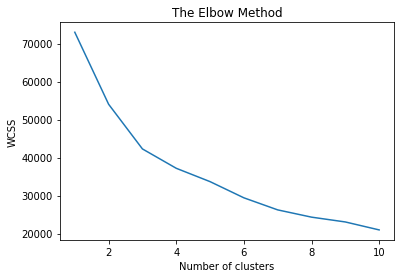

In [ ]:
#standardize the data to normal distribution


import matplotlib.pyplot as plt
from sklearn import preprocessing
# find the appropriate cluster number
#plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(cluster_familiar)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Values Count

In [ ]:
import json
import pandas as pd 

data = pd.read_csv("recomendaciones_similares.csv") 

data.head()

,Unnamed: 0,dni_cliente,pel_id1,recomendacion1,valor1,pel_id2,recomendacion2,valor2
0,0,000000001,NaN,"ANGRY BIRDS 2, LA PELICULA",1.0,NaN,NaN,NaN
1,1,000000006,NaN,NaN,NaN,NaN,NaN,NaN
2,2,000327991,NaN,NaN,NaN,NaN,NaN,NaN
3,3,000830330,NaN,NaN,NaN,NaN,NaN,NaN
4,4,000884998,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.shape

(279944, 8)

In [ ]:
print(data.shape)
import pandas as pd


value_counts_1 = data.recomendacion1.value_counts(dropna=True, sort=True)
print(value_counts_1)
print(type(value_counts_1))

print('____________________________________________________________')
print()

value_counts_2 = data['recomendacion2'].value_counts(dropna=True, sort=True)
print(value_counts_2)
print(type(value_counts_2))

IT: CAPÍTULO 2                                    76279
ANGRY BIRDS 2, LA PELICULA                        25946
BODA SANGRIENTA                                   18731
PRESIDENTE BAJO FUEGO                              5667
EL REY LEÓN                                        3208
METALLICA & SAN FRANCISCO SYMPHONY: S&M2            160
HABÍA UNA VEZ EN HOLLYWOOD                           92
HOMELESS                                             54
HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD       15
Name: recomendacion1, dtype: int64
<class 'pandas.core.series.Series'>
____________________________________________________________

PRESIDENTE BAJO FUEGO                             76258
HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD    17359
BODA SANGRIENTA                                   16626
RÁPIDOS Y FURIOSOS: HOBBS & SHAW                   5659
IT: CAPÍTULO 2                                     1893
EL REY LEÓN                                         636
ANGRY BIRDS 2, LA PELICULA 

In [ ]:
value_counts_1.to_csv(index=False)

c:\users\juan cabeza\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


'76279\r\n25946\r\n18731\r\n5667\r\n3208\r\n160\r\n92\r\n54\r\n15\r\n'

In [ ]:
 data.recomendacion1.value_counts(normalize=True)

IT: CAPÍTULO 2                                    0.586076
ANGRY BIRDS 2, LA PELICULA                        0.199352
BODA SANGRIENTA                                   0.143916
PRESIDENTE BAJO FUEGO                             0.043541
EL REY LEÓN                                       0.024648
METALLICA & SAN FRANCISCO SYMPHONY: S&M2          0.001229
HABÍA UNA VEZ EN HOLLYWOOD                        0.000707
HOMELESS                                          0.000415
HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD    0.000115
Name: recomendacion1, dtype: float64

# Validación Datos

In [ ]:
import json
import pandas as pd 
import numpy as np
import pymysql


data = pd.read_csv("recomendaciones_similares.csv") 

data.head()

,Unnamed: 0,dni_cliente,pel_id1,recomendacion1,valor1,pel_id2,recomendacion2,valor2
0,0,000000001,NaN,"ANGRY BIRDS 2, LA PELICULA",1.0,NaN,NaN,NaN
1,1,000000006,NaN,NaN,NaN,NaN,NaN,NaN
2,2,000327991,NaN,NaN,NaN,NaN,NaN,NaN
3,3,000830330,NaN,NaN,NaN,NaN,NaN,NaN
4,4,000884998,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

print("Inicio del programa de recomendacion por filtros colaborativos, basada en usuarios .....")

#####################################################################################
############################ CONEXION A LA BASE DE DATOS ############################
#####################################################################################

print("Conexion a la base de datos...")

# PELICULAS VISTAS POR LOS CLIENTES ENTRE SEIS MESES Y UNA SEMANA ATRAS.
connection = pymysql.connect(host="mel.analytics.cl", user="jterrazas",password="11jterrazas54",db="Cineplanet_Chile", port=33060)
query_movies = "SELECT CLI_ID, PEL_NOMBRE_COMERCIAL AS TITULO, STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') AS FECHA, A.PEL_ID, IF(SUM(CANTIDAD)>=1, 1, 0) AS CONTEO FROM `DIM_PELICULA` A JOIN `BOLETERIA` B ON A.PEL_ID = B.PEL_ID WHERE STR_TO_DATE(PEL_FECHA_ESTRENO, '%m/%d/%Y') BETWEEN DATE_SUB(NOW(), INTERVAL 6 MONTH) AND DATE_SUB(NOW(), INTERVAL 0 MONTH) GROUP BY CLI_ID, TITULO ORDER BY CLI_ID ASC;"
movies = pd.read_sql(query_movies, connection)
df_movies = movies.pivot(index='CLI_ID', columns='TITULO', values='CONTEO').fillna(0)
df_movies = pd.DataFrame(df_movies.to_records())
# CLIENTES POR SEGMENTACION
connection = pymysql.connect(host="mel.analytics.cl", user="jterrazas",password="11jterrazas54",db="", port=33060)
query = "SELECT B.CLI_DNI, B.CLI_ID, A.nuevo_cluster FROM cparra.cineplanet_agosto A LEFT JOIN Cineplanet_Chile.DIM_CLIENTE B ON A.cli_dni=B.CLI_DNI;"
segmentacion = pd.read_sql(query, connection)

clientes = pd.merge(df_movies,segmentacion, left_on ='CLI_ID', right_on ='CLI_ID', how='inner')

print('Creacion matriz de peliculas vistas por cliente realizada!')

Inicio del programa de recomendacion por filtros colaborativos, basada en usuarios .....
Conexion a la base de datos...
Creacion matriz de peliculas vistas por cliente realizada!


In [ ]:
join = pd.merge(clientes, data, left_on='CLI_DNI', right_on='dni_cliente', how='left')
join.head()

,CLI_ID,EL PRÍNCIPE ENCANTADOR,A DOS METROS DE TI,AFTER: AQUÍ EMPIEZA TODO,ALADDIN,"ANGRY BIRDS 2, LA PELICULA",ANNA,ANNABELLE 3: VIENE A CASA,AVENGERS: ENDGAME,AVENGERS: ENDGAME EXTENDIDA,...,CLI_DNI,nuevo_cluster,Unnamed: 0,dni_cliente,pel_id1,recomendacion1,valor1,pel_id2,recomendacion2,valor2
0,711654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,000000001,JOVEN,0.0,000000001,NaN,"ANGRY BIRDS 2, LA PELICULA",1.0,NaN,NaN,NaN
1,711673,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,000327991,FAMILIAR,2.0,000327991,NaN,NaN,NaN,NaN,NaN,NaN
2,711687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,000830330,JOVEN,3.0,000830330,NaN,NaN,NaN,NaN,NaN,NaN
3,711694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,000884998,TOP,4.0,000884998,NaN,NaN,NaN,NaN,NaN,NaN
4,711700,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,000902810,FAMILIAR,5.0,000902810,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
join_1 = join[['CLI_ID','CLI_DNI','nuevo_cluster','recomendacion1', 'recomendacion2' ]]
join_1.head()

,CLI_ID,CLI_DNI,nuevo_cluster,recomendacion1,recomendacion2
0,711654,000000001,JOVEN,"ANGRY BIRDS 2, LA PELICULA",NaN
1,711673,000327991,FAMILIAR,NaN,NaN
2,711687,000830330,JOVEN,NaN,NaN
3,711694,000884998,TOP,NaN,NaN
4,711700,000902810,FAMILIAR,NaN,NaN


In [ ]:
all_items = pd.concat([join_1.recomendacion1, join_1.recomendacion2])

temp_df = pd.concat([join_1[["nuevo_cluster"]].copy(), join_1[["nuevo_cluster"]].copy()])
temp_df["ITEM"] = all_items
temp_df.reset_index(inplace=True)
temp_df["temp_col"] = 1

my_pivot = temp_df.pivot_table(values="temp_col", index="nuevo_cluster", columns="ITEM", aggfunc=np.sum, fill_value=0)
my_pivot = my_pivot / len(join_1)
# my_pivot / len (df) # <-- changing this to
to_div = my_pivot.aggregate(np.sum, axis=1) # <-- this and
my_pivot = my_pivot.div(to_div, axis=0) 

my_pivot

ITEM,"ANGRY BIRDS 2, LA PELICULA",BODA SANGRIENTA,EL REY LEÓN,HABÍA UNA VEZ EN HOLLYWOOD,HISTORIAS DE MIEDO PARA CONTAR EN LA OSCURIDAD,HOMELESS,IT: CAPÍTULO 2,METALLICA & SAN FRANCISCO SYMPHONY: S&M2,PRESIDENTE BAJO FUEGO,RÁPIDOS Y FURIOSOS: HOBBS & SHAW
nuevo_cluster,,,,,,,,,,
BAJO,0.123122,0.188597,0.022576,0.001148,0.101723,0.000486,0.277664,0.000221,0.280137,0.004327
BLACK,0.161920,0.197578,0.011213,0.003588,0.085669,0.000449,0.169320,0.001570,0.271137,0.097556
FAMILIAR,0.082236,0.079030,0.009313,0.000273,0.034608,0.000091,0.392386,0.000030,0.396548,0.005484
JOVEN,0.125025,0.131291,0.014606,0.001221,0.056430,0.000041,0.302575,0.000325,0.326661,0.041824
ORO,0.104702,0.160954,0.012391,0.003432,0.074081,0.000134,0.258970,0.001382,0.310140,0.073813
TOP,0.103194,0.150010,0.015808,0.002149,0.074133,0.000156,0.303524,0.000732,0.320921,0.029373


In [ ]:
my_pivot.sum(axis = 1)

nuevo_cluster
BAJO        1.0
BLACK       1.0
FAMILIAR    1.0
JOVEN       1.0
ORO         1.0
TOP         1.0
dtype: float64